# **Movie Recomemder System.**

### ***1.0 Description***

The movie recommender system aims to provide personalized movie recommendations to users based on ratings. By using data on movie genres and ratings, the system will predict and suggest movies that users are likely to enjoy.

The system will use collaborative filtering (user - based) to make suggestions for each user.

### ***1.1 Business Problem***

Users finds it difficult to choose content that matches thier preferences. Lack of personalized recommendations leads to users disatisfaction.

The recommender system will:
 - Help users to discover new content that they may enjoy based on their unique preferences.

 - Enhance user experience by providing personalized movie recommendations.

 - Ensure viewers are exposed to a variety of relevant movies

### ***1.2 Objectives***

- Peformance avaluation of the models

- Accuracy of the models

- Personalization

- User engagement

### ***1.3 Shareholders***

- `End users` - these are the people who consume the content and are relying on reccomendations.

- `Content creators` - these are people who are producing the content

- `marketing team` - these team will rely on the system to come up with a marketing strategy

- `product team` - these are for integrating the system into the platforms

### ***2.0 Data loading and data Understanding***

### 2.1 necessary Libraries

In [3]:
#importing the necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import SVD
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


### 2.2 Loading the movie and Rating data sets


In [14]:
# data loading and checking the head
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


The datasets have the following colums:

- ` movieID` - uniquely identifies a movie 

- ` title` - name of a movie

- `genres` - genre to which a movie belongs

- `userID` - uniquely identifying each user

- ` rating` - a rating given to movies by users

- `timestamp` - time the movies were released

### Merge the two data sets

In [45]:
movie_rating = pd.merge(ratings, movies, on="movieId")
movie_rating.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [47]:
movie_rating = movie_rating.drop(columns = ['timestamp'], axis = 1)
movie_rating.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [17]:
movie_rating.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

In [22]:
movie_rating['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

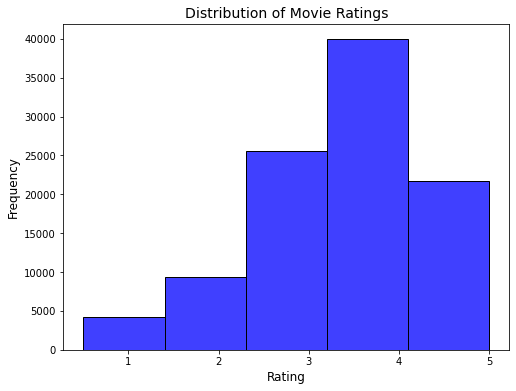

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(movie_rating['rating'], bins=5, kde=False, color='blue')  


plt.title('Distribution of Movie Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

In [21]:
top_genre_titles = movie_rating.groupby('title')['rating'].mean()

top_50_genres = top_genre_titles.sort_values(ascending=False).head(50)

print(top_50_genres)

title
Karlson Returns (1970)                                            5.0
Winter in Prostokvashino (1984)                                   5.0
My Love (2006)                                                    5.0
Sorority House Massacre II (1990)                                 5.0
Winnie the Pooh and the Day of Concern (1972)                     5.0
Sorority House Massacre (1986)                                    5.0
Bill Hicks: Revelations (1993)                                    5.0
My Man Godfrey (1957)                                             5.0
Hellbenders (2012)                                                5.0
In the blue sea, in the white foam. (1984)                        5.0
Won't You Be My Neighbor? (2018)                                  5.0
Red Sorghum (Hong gao liang) (1987)                               5.0
Love Exposure (Ai No Mukidashi) (2008)                            5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)                       5.0
The Love Bug (

### 3.0 Data preparation for surprise


- Surprise is a liblary used to build recommendation systems

- Surprise  offers several algorithms for collaborative filtering (e.g., Singular Value Decomposition, K-Nearest Neighbors).

- It provides tools for evaluating the performance of models using standard metrics.

In [27]:
reader = Reader (rating_scale= (0.5, 5.0))
data = Dataset.load_from_df(movie_rating[["userId", "movieId", "rating"]], reader)
data

In [28]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


looking at how many users and items we have in our dataset. when using neighborhood-based methods, this helps in determining whether or not we should perform user-user or item-item similarity.

from the dataset, we will be using the user-based systems

### 3.1 Modeling with SVD using gridsearch

- `GridSearch` is a technique used to find the best combination of hyperparameters

In [29]:
params = {'n_factors': [30, 50, 100], 
          'reg_all':[0.02,0.03,0.05]}
grid_s_svd = GridSearchCV(SVD, param_grid=params)
grid_s_svd.fit(data)

In [30]:
print(grid_s_svd.best_score)
print(grid_s_svd.best_params)

{'rmse': 0.8685564163588152, 'mae': 0.667580971025087}
{'rmse': {'n_factors': 50, 'reg_all': 0.03}, 'mae': {'n_factors': 30, 'reg_all': 0.03}}


- ` rmse` for the SVD is around 86.85%
- ` gridsearch` best parameters are `n_factors = 50` and `reg_all = 0.03`

### 3.2 cross validating with KNNBasic

In [31]:
knn_basic = KNNBasic(sim_options= {'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs = 1)
cv_knn_basic['test_rmse']
print(np.mean(cv_knn_basic['test_rmse']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.9736106280149903


- `test_rmse` for this model is around 97.36 % an improvement from SVD

- `pearson` is the similarity metrics 

- ` KNNBasic` for computing the similarity scores and making predictions

- ` User_based = TRUE` a type of filtering for user_based system

### 3.3 cross validating with KNNBaseline

In [32]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson','user_based': True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs= 1)
cv_knn_baseline['test_rmse']
print(np.mean(cv_knn_baseline['test_rmse']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.8767791397508699


- ` test_rmse` for this model is around 87.67
%

### 3.4 cross validating with KNNWithMeans

In [33]:
knn_with_means = KNNWithMeans(sim_options={'name':'pearson','user_based': True})
cv_knn_with_means = cross_validate(knn_with_means, data, n_jobs= 1)
cv_knn_with_means['test_rmse']
print(np.mean(cv_knn_with_means['test_rmse']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.8958872825738918


- ` test_rmse` for this model is around 89.58%


`RMSE` is used to evaluate the accuracy of predicted ratings. It measures the average difference between predicted and actual ratings (how close or far apart the predictions are from the actual values).

`Lower RMSE` indicates a better fit of the model

From the above outputs, SVD seems to be the best performing model with a test RMSE of around `86.85 %`

We will therefore use SVD to make predictions

In [34]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

### User ratings

In [39]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [43]:
user_rating = movie_rater(movies, 10, 'Comedy')

      movieId                        title               genres
4119     5909  Visitor Q (Bizita Q) (2001)  Comedy|Drama|Horror
      movieId                 title        genres
7575    86028  Henry's Crime (2010)  Comedy|Crime
      movieId                                              title  \
6624    56060  I Served the King of England (Obsluhoval jsem ...   

                        genres  
6624  Comedy|Drama|Romance|War  
      movieId             title  genres
7373    79134  Grown Ups (2010)  Comedy
      movieId                title  genres
2175     2891  Happy, Texas (1999)  Comedy
      movieId             title  genres
3525     4816  Zoolander (2001)  Comedy
      movieId          title  \
7441    81132  Rubber (2010)   

                                                 genres  
7441  Action|Adventure|Comedy|Crime|Drama|Film-Noir|...  
      movieId                          title  genres
8804   130498  La vérité si je mens ! (1997)  Comedy
     movieId                    titl

In [52]:
new_df = movie_rating.drop(columns = ['genres', 'title'], axis = 1)
new_df.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
